## Regression with a CNN

In the previous exercise, we use a CNN model to solve a classification problem—namely MNIST handwritten digits.

In this exercise, we will used the same model to solve a regression problem: namely, estimating the centrioid $(x_{\text{c}}, y_{\text{c}})$, as well as the radii $r_{x}$ and $r_{y}$ of an ellipse. Recall: an ellipse is defined by
$$
\frac{(x - x_{\text{c}})^{2}}{r_{x}} + \frac{(y - y_{\text{c}})^{2}}{r_{y}} = 1
$$

### Task 1: Accessing some data

For this project, I have created a very simple dataset which yields an image of an ellipse, along with the various parameters which define it as targets.


In [12]:
from ml_workshop import EllipseDataset

dataset = EllipseDataset(training=True)

To understand the data, and how they are presented to us, the easiest thing to do is to plot them. Let's first grab five input--target pairs, plot the images and then overlay the target information.

In [13]:
pairs = []
for idx in range(5):
    pairs.append(dataset[idx])

# If you have a list of tuples, you "unzip" them into individual lists this way
imgs, targets = zip(*pairs)

- What types have the image data?
- What types have the target data?
- How are they presented to us?

In [14]:
print(f"The images are of type '{type(imgs[0])}'")
print(f"The targets are of type '{type(targets[0])}'")

print(f"The images have shape '{imgs[0].shape}'")
print(f"The targets have shape '{targets[0].shape}'")

The images are of type '<class 'numpy.ndarray'>'
The targets are of type '<class 'numpy.ndarray'>'
The images have shape '(128, 128, 3)'
The targets have shape '(4,)'


- The images are RGB arrays of shape ``(height, width, colour_channels)``.
- The targets are arrays holding the coordinate information:
  - ``(row_center, col_center, row_radius, col_radius)``.
  - There are the four parameters required to define an ellipse.



Let us now plot the images, and overlay the target information.

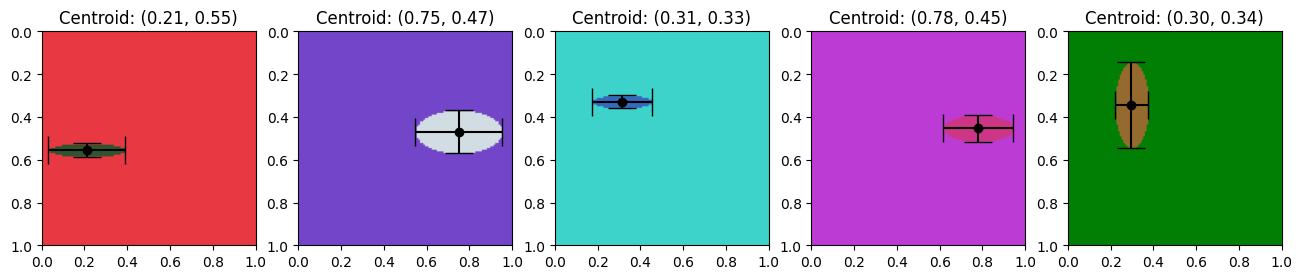

In [15]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, len(pairs), figsize=(16, 4))

for x, y, axis in zip(imgs, targets, axes.ravel()):
    axis.imshow(x, extent=(0, 1, 1, 0))
    axis.errorbar(
        y[1],
        y[0],
        xerr=y[3],
        yerr=y[2],
        marker="o",
        color="k",
        capsize=10,
    )
    axis.set_title(f"Centroid: ({y[1]:.2f}, {y[0]:.2f})")

#### Note: The coordinate information is always expressed in fractions of the linear dimension of the images, so we don't need to worry about normalising the data, and we have natural bounds for the interval on which our predictions should lie.

### Task 3: ``Dataset`` $\to$ ``DataLoader``

As before, wrap the ``Dataset``'s in ``DataLoader``s.

- First, reinstantiate the datasets, and provide ``Compose`` objects containing the transforms required to map from numpy arrays to torch tensors.

In [16]:
from torchvision.transforms import Compose, ToTensor
from torch import from_numpy

from torch.utils.data import DataLoader

train_set = EllipseDataset(
    training=True,
    # input_tfms=???,
    # target_tfms=???,
)
valid_set = EllipseDataset(
    training=False,
    # input_tfms=???,
    # target_tfms=???,
)


batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

### Task 4: Choose a model architecture

Let's use the same CNN as we did before, as it is relatively small.

- Instantiate the model and print it out.

In [17]:
from torchvision.models import mobilenet_v3_small
from torchvision.models import MobileNet_V3_Small_Weights

model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT)
print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

#### Task 5: Uh oh, we've a problem—again.
 - The model again has 1000 output features.
   - How many do we need?
- Modify the number of output features, as we did in the previous exercise, accordingly.

In [18]:
from torch.nn import Linear

# model.classifier[3] = Linear(model.classifier[3].in_features, ???)

### Task 5: Set up the remaining PyTorch bits and bobs

- We need to choose a loss function appropriate for _regression_.
  - Can you remember what we chose previously?
- We need an optimiser, too.
  - Remember our friend, Adam?
- Instantiate the model and loss function.

In [19]:
# from torch.nn import MSELoss
# from torch.optim import Adam

# loss_func = MSELoss(???)

# optimiser = Adam(???)

### Task 6: Set the device

In [20]:
from torch.cuda import is_available

DEVICE = "cuda" if is_available() else "cpu"

# Note: here the return/assignment to ``_`` is just to supress the print.
# The model is moved onto the correct device in-place.
_ = model.to(DEVICE)

### Task 7: Writing our training and validation loops

As before, we need to write our training and validation loops.

- Complete the training loop
- Complete the validation loop
- What metrics can we extraction in a regression problem?


Things to consider:
- We might use the ``ReLU`` activation function to stop our outputs being negative.
- What other activation functions might we use to bound our outputs?

In [23]:
from typing import Dict

from torch import no_grad
from torch.nn import Module


def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: MSELoss,
) -> Dict[str, float]:
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        A neural network.
    train_loader : DataLoader
        The ``DataLoader`` for the training set.
    optimiser : Adam
        The optimiser to update the model's parameters with.
    loss_func : BCELoss
        Binary-cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    """
    model.train()

    running_loss = 0.0
    for batch, targets in train_loader:
        pass


@no_grad()
def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    optimiser: Adam,
    loss_func: MSELoss,
) -> Dict[str, float]:
    """Train the model for a single epoch.

    Parameters
    ----------
    model : Module
        A neural network.
    train_loader : DataLoader
        The ``DataLoader`` for the training set.
    loss_func : BCELoss
        Binary-cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    """
    model.eval()

    running_loss = 0.0
    for batch, targets in train_loader:
        pass


### Task 8: Training, extracting and plotting metrics

- Now we can train our model for a specified number of epochs.
  - One epoch is where the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turm them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict[str, float]]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.
- Use Matplotlib to plot the training and validation metrics as a function of the number of epochs.

In [24]:
from pandas import DataFrame

epochs = 10

train_metrics, valid_metrics = [], []

for _ in range(epochs):
    
    # Let's call our training and validation functions, and store their output
    pass



### Task 9: Plotting our metrics

- Plot the loss for the training and validation sets at the end of each epoch.

In [ ]:
figure, axis = plt.subplots(1, 1)

# axis.plot(???, "-o", label="Training loss")
# axis.plot(???, "-o", label="Validation loss")


# axis.legend()

# axis.set_xlabel("Epoch")
# axis.set_ylabel("MSE Loss")

# axis.set_ylim(bottom=0.0)

Task 10: Visualising some results

- When we first looked at the data, we plotted the images and overlayed the coordinate information.
  - Let's do this again, now using the model's predictions rather than the ground truths.


In [ ]:
# This simply grabs us one mini-batch of data.
batch, targets = next(iter(valid_loader))

model = model.to("cpu")

with no_grad():
    pass
    # preds = model(batch).??? — what activation should we use?


figure, axes = plt.subplots(1, len(preds), figsize=(len(preds) * 2.5, 2.5))

for image, pred, axis in zip(batch, preds, axes.ravel()):
    axis.imshow(image.permute(1, 2, 0), extent=(0, 1, 1, 0))
    axis.errorbar(
        pred[1].item(),
        pred[0].item(),
        marker="o",
        yerr=pred[2].item(),
        xerr=pred[3].item(),
        color="k",
        capsize=10,
    )

    axis.set_xlim(left=0.0, right=1.0)
    axis.set_ylim(bottom=0.0, top=1.0)

### Task 11

- Re-run the previous cell over and over.
- Do the results look good, or rubbish?
- Train the model for longer—say 50 epochs—and revaluate.
- Go have lunch, with a smile.
